##### Copyright 2019 The TensorFlow IO Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Decode DICOM files for medical imaging

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/io/tutorials/dicom"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/io/blob/master/docs/tutorials/dicom.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/io/blob/master/docs/tutorials/dicom.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
      <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/io/docs/tutorials/dicom.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial shows how to use `tfio.image.decode_dicom_image` in TensorFlow IO to decode DICOM files with TensorFlow.

## Setup and Usage

#### Download DICOM image

The DICOM image used in this tutorial is from the [NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

The NIH Chest X-ray dataset consists of 100,000 de-identified images of chest x-rays in PNG format, provided by NIH Clinical Center and could be downloaded through [this link](https://nihcc.app.box.com/v/ChestXray-NIHCC).

Google Cloud also provides a DICOM version of the images, available in [Cloud Storage](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).

In this tutorial, you will download a sample file of the dataset from the [GitHub repo](https://github.com/tensorflow/io/raw/master/docs/tutorials/dicom/dicom_00000001_000.dcm)


Note: For more information about the dataset, please find the following reference:

- Xiaosong Wang, Yifan Peng, Le Lu, Zhiyong Lu, Mohammadhadi Bagheri, Ronald Summers, ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases, IEEE CVPR, pp. 3462-3471, 2017


In [1]:
!curl -OL https://github.com/tensorflow/io/raw/master/docs/tutorials/dicom/dicom_00000001_000.dcm
!ls -l dicom_00000001_000.dcm

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0    512      0 --:--:-- --:--:-- --:--:--   512
100 1024k  100 1024k    0     0  1719k      0 --:--:-- --:--:-- --:--:-- 1719k
-rw-r--r-- 1 root root 1049332 Aug 10 12:29 dicom_00000001_000.dcm


### Install required Packages, and restart runtime

In [2]:
try:
  # Use the Colab's preinstalled TensorFlow 2.x
  %tensorflow_version 2.x 
except:
  pass

In [6]:
!pip install tensorflow-io

     |████████████████████████████████| 22.7 MB 1.7 MB/s 
     |████████████████████████████████| 2.3 MB 16.9 MB/s 


### Decode DICOM image

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

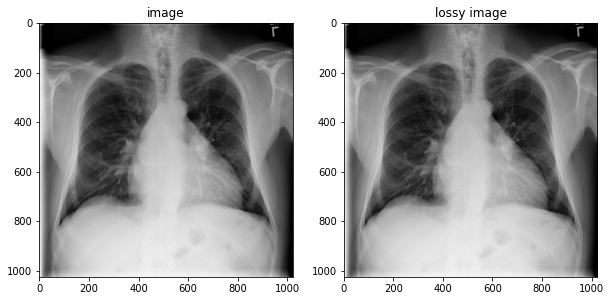

In [7]:
import tensorflow_io as tfio

image_bytes = tf.io.read_file('dicom_00000001_000.dcm')

image = tfio.image.decode_dicom_image(image_bytes, dtype=tf.uint16)

skipped = tfio.image.decode_dicom_image(image_bytes, on_error='skip', dtype=tf.uint8)

lossy_image = tfio.image.decode_dicom_image(image_bytes, scale='auto', on_error='lossy', dtype=tf.uint8)


fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].imshow(np.squeeze(image.numpy()), cmap='gray')
axes[0].set_title('image')
axes[1].imshow(np.squeeze(lossy_image.numpy()), cmap='gray')
axes[1].set_title('lossy image');

### Decode DICOM Metadata and working with Tags

`decode_dicom_data` decodes tag information. `dicom_tags` contains useful information as the patient's age and sex, so we have to use DICOM tags such as `dicom_tags.PatientsAge` and `dicom_tags.PatientsSex`. We borrow the same tag notation from the pydicom dicom package.

In [38]:
tag_id = tfio.image.dicom_tags.PatientsAge
tag_value = tfio.image.decode_dicom_data(image_bytes,tag_id)
print(tag_value)

tf.Tensor(b'58', shape=(), dtype=string)


In [36]:
print(f"PatientsAge : {tag_value.numpy().decode('UTF-8')}")

PatientsAge : 58


In [52]:
tag_id = tfio.image.dicom_tags.PatientsSex
tag_value = tfio.image.decode_dicom_data(image_bytes,tag_id)
print(f"PatientsSex : {tag_value.numpy().decode('UTF-8')}")

1048640
tf.Tensor(b'M', shape=(), dtype=string)
PatientsSex : M


## Documentation
This package has two operations which wrap `DCMTK` functions. `decode_dicom_image` decodes the pixel data from DICOM files, and `decode_dicom_data` decodes tag information. `tags` contains useful DICOM tags such as `tags.PatientsName`. The tag notation is borrowed from the [`pydicom`](https://pydicom.github.io/) dicom package.

### Getting DICOM Image Data
```python
io.dicom.decode_dicom_image(
    contents,
    color_dim=False,
    on_error='skip',
    scale='preserve',
    dtype=tf.uint16,
    name=None
)
```

 - **`contents`**: A Tensor of type string. 0-D. The byte string encoded DICOM file
 - **`color_dim`**: An optional `bool`. Defaults to `False`. If `True`, a third channel will be appended to all images forming a 3-D tensor. A 1024 x 1024 grayscale image will be 1024 x 1024 x 1
 - **`on_error`**: Defaults to `skip`. This attribute establishes the behavior in case an error occurs on opening the image or if the output type cannot accomodate all the possible input values. For example if the user sets the output dtype to `tf.uint8`, but a dicom image stores a `tf.uint16` type. `strict` throws an error. `skip` returns a 1-D empty tensor.  `lossy` continues with the operation scaling the value via the `scale` attribute. 
 - **`scale`**:  Defaults to `preserve`. This attribute establishes what to do with the scale of the input values. `auto` will autoscale the input values, if the output type is integer, `auto` will use the maximum output scale for example a `uint8` which stores values from [0, 255] can be linearly stretched to fill a `uint16` that is [0,65535]. If the output is float, `auto` will scale to [0,1]. `preserve` keeps the values as they are, an input value greater than the maximum possible output will be clipped. 
 - **`dtype`**: An optional `tf.DType` from: `tf.uint8, tf.uint16, tf.uint32, tf.uint64, tf.float16, tf.float32, tf.float64`. Defaults to `tf.uint16`. 
 - **`name`**: A name for the operation (optional).
 
 **Returns**
   A `Tensor` of type `dtype` and the shape is determined by the DICOM file. 

### Getting DICOM Tag Data
```python
io.dicom.decode_dicom_data(
    contents,
    tags=None,
    name=None
)
```

 - **`contents`**: A Tensor of type string. 0-D. The byte string encoded DICOM file
 - **`tags`**: A Tensor of type `tf.uint32` of any dimension. These `uint32` numbers map directly to DICOM tags
 - **`name`**: A name for the operation (optional).

 **Returns**
   A `Tensor` of type `tf.string` and same shape as `tags`.  If a dicom tag is a list of strings, they are combined into one string and seperated by a double backslash `\\`. There is a bug in [DCMTK](https://support.dcmtk.org/docs/) if the tag is a list of numbers, only the zeroth element will be returned as a string.



### Bibtex

If this package helped, please kindly cite the below:

```
@misc{marcelo_lerendegui_2019_3337331,
  author       = {Marcelo Lerendegui and
                  Ouwen Huang},
  title        = {Tensorflow Dicom Decoder},
  month        = jul,
  year         = 2019,
  doi          = {10.5281/zenodo.3337331},
  url          = {https://doi.org/10.5281/zenodo.3337331}
}
```

### License

Copyright 2019 Marcelo Lerendegui, Ouwen Huang, Gradient Health Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.